In [3]:
import tensorflow as tf
from numba import njit
import pickle
from tensorflow.keras.regularizers import l2
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

from deep_bayes.losses import maximum_likelihood_loss

# Models

In [21]:
class Permutation(tf.keras.Model):
    """Implements a permutation layer to permute the input dimensions of the cINN block."""

    def __init__(self, input_dim):
        """
        Creates a permutation layer for a conditional invertible block.
        ----------

        Arguments:
        input_dim  : int -- the dimensionality of the input to the c inv block.
        """

        super(Permutation, self).__init__()

        permutation_vec = np.random.permutation(input_dim)
        inv_permutation_vec = np.argsort(permutation_vec)
        self.permutation = tf.Variable(initial_value=permutation_vec,
                                       trainable=False,
                                       dtype=tf.int32,
                                       name='permutation')
        self.inv_permutation = tf.Variable(initial_value=inv_permutation_vec,
                                           trainable=False,
                                           dtype=tf.int32,
                                           name='inv_permutation')

    def call(self, x, inverse=False):
        """Permutes the bach of an input."""

        if not inverse:
            return tf.transpose(tf.gather(tf.transpose(x), self.permutation))
        return tf.transpose(tf.gather(tf.transpose(x), self.inv_permutation))


class CouplingNet(tf.keras.Model):
    """Implements a conditional version of a sequential network."""

    def __init__(self, meta, n_out):
        """
        Creates a conditional coupling net (FC neural network).
        ----------

        Arguments:
        meta  : list -- a list of dictionaries, wherein each dictionary holds parameter - value pairs for a single
                       tf.keras.Dense layer.
        n_out : int  -- number of outputs of the coupling net
        """

        super(CouplingNet, self).__init__()

        self.dense = tf.keras.Sequential(
            # Hidden layer structure
            [tf.keras.layers.Dense(units,
                                   activation=meta['activation'],
                                   kernel_initializer=meta['initializer'],
                                   kernel_regularizer=l2(meta['w_decay']))
             for units in meta['n_units']] +
            # Output layer
            [tf.keras.layers.Dense(n_out,
                                   kernel_initializer=meta['initializer'],
                                   kernel_regularizer=l2(meta['w_decay']))]
        )

    def call(self, theta, x):
        """
        Concatenates x and y and performs a forward pass through the coupling net.
        Arguments:
        theta : tf.Tensor of shape (batch_size, inp_dim)     -- the parameters x ~ p(x|y) of interest
        x     : tf.Tensor of shape (batch_size, summary_dim) -- the summarized conditional data of interest y = sum(y)
        """

        inp = tf.concat((theta, x), axis=-1)
        out = self.dense(inp)
        return out


class ConditionalInvertibleBlock(tf.keras.Model):
    """Implements a conditional version of the INN block."""

    def __init__(self, meta, theta_dim, alpha=1.9, permute=False):
        """
        Creates a conditional invertible block.
        ----------

        Arguments:
        meta      : list -- a list of dictionaries, wherein each dictionary holds parameter - value pairs for a single
                       tf.keras.Dense layer. All coupling nets are assumed to be equal.
        theta_dim : int  -- the number of outputs of the invertible block (eq. the dimensionality of the latent space)
        """

        super(ConditionalInvertibleBlock, self).__init__()
        self.alpha = alpha
        self.n_out1 = theta_dim // 2
        self.n_out2 = theta_dim // 2 if theta_dim % 2 == 0 else theta_dim // 2 + 1
        if permute:
            self.permutation = Permutation(theta_dim)
        else:
            self.permutation = None
        self.s1 = CouplingNet(meta, self.n_out1)
        self.t1 = CouplingNet(meta, self.n_out1)
        self.s2 = CouplingNet(meta, self.n_out2)
        self.t2 = CouplingNet(meta, self.n_out2)

    def call(self, theta, x, inverse=False, log_det_J=True):
        """
        Implements both directions of a conditional invertible block.
        ----------

        Arguments:
        theta     : tf.Tensor of shape (batch_size, theta_dim) -- the parameters theta ~ p(theta|y) of interest
        x         : tf.Tensor of shape (batch_size, summary_dim) -- the summarized conditional data of interest x = sum(x)
        inverse   : bool -- flag indicating whether to tun the block forward or backwards
        log_det_J : bool -- flag indicating whether to return the log determinant of the Jacobian matrix
        ----------

        Returns:
        (v, log_det_J)  :  (tf.Tensor of shape (batch_size, inp_dim), tf.Tensor of shape (batch_size, )) --
                           the transformed input, if inverse = False, and the corresponding Jacobian of the transformation
                            if inverse = False
        u               :  tf.Tensor of shape (batch_size, inp_dim) -- the transformed out, if inverse = True
        """

        # --- Forward pass --- #
        if not inverse:

            if self.permutation is not None:
                theta = self.permutation(theta)

            u1, u2 = tf.split(theta, [self.n_out1, self.n_out2], axis=-1)

            # Pre-compute network outputs for v1
            s1 = self.s1(u2, x)
            # Clamp s1 if specified
            if self.alpha is not None:
                s1 = (2. * self.alpha / np.pi) * tf.math.atan(s1 / self.alpha)
            t1 = self.t1(u2, x)
            v1 = u1 * tf.exp(s1) + t1

            # Pre-compute network outputs for v2
            s2 = self.s2(v1, x)
            # Clamp s2 if specified
            if self.alpha is not None:
                s2 = (2. * self.alpha / np.pi) * tf.math.atan(s2 / self.alpha)
            t2 = self.t2(v1, x)
            v2 = u2 * tf.exp(s2) + t2
            v = tf.concat((v1, v2), axis=-1)

            if log_det_J:
                # log|J| = log(prod(diag(J))) -> according to inv architecture
                return v, tf.reduce_sum(s1, axis=-1) + tf.reduce_sum(s2, axis=-1)
            return v

        # --- Inverse pass --- #
        else:

            v1, v2 = tf.split(theta, [self.n_out1, self.n_out2], axis=-1)

            # Pre-Compute s2
            s2 = self.s2(v1, x)
            # Clamp s2 if specified
            if self.alpha is not None:
                s2 = (2. * self.alpha / np.pi) * tf.math.atan(s2 / self.alpha)
            u2 = (v2 - self.t2(v1, x)) * tf.exp(-s2)

            # Pre-Compute s1
            s1 = self.s1(u2, x)
            # Clamp s1 if specified
            if self.alpha is not None:
                s1 = (2. * self.alpha / np.pi) * tf.math.atan(s1 / self.alpha)
            u1 = (v1 - self.t1(u2, x)) * tf.exp(-s1)
            u = tf.concat((u1, u2), axis=-1)

            if self.permutation is not None:
                u = self.permutation(u, inverse=True)
            return u


class BayesFlow(tf.keras.Model):
    """Implements a chain of conditional invertible blocks for Bayesian parameter inference."""

    def __init__(self, meta, n_blocks, theta_dim, alpha=1.9, summary_net=None, permute=False):
        """
        Creates a chain of cINN blocks and chains operations.
        ----------

        Arguments:
        meta        : list -- a list of dictionary, where each dictionary holds parameter - value pairs for a single
                                  keras.Dense layer
        n_blocks    : int  -- the number of invertible blocks
        theta_dim   : int  -- the dimensionality of the parameter space to be learned
        summary_net : tf.keras.Model or None -- an optinal summary network for learning the sumstats of x
        permute     : bool -- whether to permute the inputs to the cINN
        """

        super(BayesFlow, self).__init__()

        self.cINNs = [ConditionalInvertibleBlock(meta, theta_dim, alpha=alpha, permute=permute) for _ in range(n_blocks)]
        self.summary_net = summary_net
        self.theta_dim = theta_dim

    def call(self, theta, x, inverse=False):
        """
        Performs one pass through an invertible chain (either inverse or forward).
        ----------

        Arguments:
        theta     : tf.Tensor of shape (batch_size, inp_dim) -- the parameters theta ~ p(theta|x) of interest
        x         : tf.Tensor of shape (batch_size, summary_dim) -- the conditional data x
        inverse   : bool -- flag indicating whether to tun the chain forward or backwards
        ----------

        Returns:
        (z, log_det_J)  :  (tf.Tensor of shape (batch_size, inp_dim), tf.Tensor of shape (batch_size, )) --
                           the transformed input, if inverse = False, and the corresponding Jacobian of the transformation
                            if inverse = False
        x               :  tf.Tensor of shape (batch_size, inp_dim) -- the transformed out, if inverse = True
        """

        if self.summary_net is not None:
            x = self.summary_net(x)
        if inverse:
            return self.inverse(theta, x)
        else:
            return self.forward(theta, x)

    def forward(self, theta, x):
        """Performs a forward pass though the chain."""

        z = theta
        log_det_Js = []
        for cINN in self.cINNs:
            z, log_det_J = cINN(z, x)
            log_det_Js.append(log_det_J)
        # Sum Jacobian determinants for all blocks to obtain total Jacobian.
        log_det_J = tf.add_n(log_det_Js)
        return {'z': z, 'log_det_J': log_det_J}

    def inverse(self, z, x):
        """Performs a reverse pass through the chain."""

        theta = z
        for cINN in reversed(self.cINNs):
            theta = cINN(theta, x, inverse=True)
        return theta

    def sample(self, x, n_samples, to_numpy=False, training=False):
        """
        Samples from the inverse model given a single instance y or a batch of instances.
        ----------

        Arguments:
        x         : tf.Tensor of shape (batch_size, summary_dim) -- the conditioning data of interest
        n_samples : int -- number of samples to obtain from the approximate posterior
        to_numpy  : bool -- flag indicating whether to return the samples as a np.array or a tf.Tensor
        training  : bool -- flag used to indicate that samples are drawn are training time (BatchNorm)
        ----------

        Returns:
        theta_samples : 3D tf.Tensor or np.array of shape (n_samples, n_batch, theta_dim)
        """

        # Summarize obs data if summary net available
        if self.summary_net is not None:
            x = self.summary_net(x, training=training)

        # In case x is a single instance
        if int(x.shape[0]) == 1:
            z_normal_samples = tf.random.normal(shape=(n_samples, self.theta_dim), dtype=tf.float32)
            theta_samples = self.inverse(z_normal_samples, tf.tile(x, [n_samples, 1]))
        # In case of a batch input, send a 3D tensor through the invertible chain and use tensordot
        # Warning: This tensor could get pretty big if sampling a lot of values for a lot of batch instances!
        else:
            z_normal_samples = tf.random.normal(shape=(n_samples, int(x.shape[0]), self.theta_dim), dtype=tf.float32)
            theta_samples = self.inverse(z_normal_samples, tf.stack([x] * n_samples))

        if to_numpy:
            return theta_samples.numpy()
        return theta_samples

In [5]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        meta : dict -- a dictionary with hyperparameter name - values
        """

        super(InvariantModule, self).__init__()


        self.pre_pooling_fc = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])

            

        self.post_pooling_fc = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])

    def call(self, x):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        # Embed
        x_equiv = self.pre_pooling_fc(x)

        # Pool
        x_pooled = tf.reduce_mean(x_equiv, axis=1)
    
        # Increase representational power
        out = self.post_pooling_fc(x_pooled)
        return out


class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------

        Arguments:
        meta : dict -- a dictionary with hyperparameter name - values
        """

        super(EquivariantModule, self).__init__()

        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_equiv_args'])
            for _ in range(meta['n_dense_equiv'])
        ])

        self.invariant_module = InvariantModule(meta)

    def call(self, x):
        """
        Transofrms the input into an equivariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x_inv = self.invariant_module(x)
        x_inv = tf.stack([x_inv] * int(x.shape[1]), axis=1) # Repeat x_inv n times
        x = tf.concat((x_inv, x), axis=-1)
        out = self.module(x)
        return out


class InvariantNetwork(tf.keras.Model):
    """
    Implements a network which parameterizes a
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, meta):
        """
        Creates a permutationally invariant network
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        meta : dict -- hyperparameter settings for the equivariant and invariant modules
        """

        super(InvariantNetwork, self).__init__()

        self.equiv = tf.keras.Sequential([
            EquivariantModule(meta)
            for _ in range(meta['n_equiv'])
        ])
        self.inv = InvariantModule(meta)


    def call(self, x, **kwargs):
        """
        Transofrms the input into a permutationally invariant
        representation by first passing it through multiple equivariant
        modules in order to increase representational power.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or
        'samples' dimensions over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.equiv(x)
        out = self.inv(x)
        return out
    
    
class SummaryNet(tf.keras.Model):
    """
    Implements a network which parameterizes a
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, meta):
        """
        Creates a permutationally invariant network
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        meta : dict -- hyperparameter settings for the equivariant and invariant modules
        """

        super(SummaryNet, self).__init__()

        self.inv = InvariantNetwork(meta)
        self.post = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_post_args'])
            for _ in range(meta['n_dense_post'])
        ])
        
    def call(self, x, **kwargs):
        
        if not isinstance(x, list):
            rep = tf.split(x, 6, axis=1)
        else:
            rep = x
        rep = tf.concat([self.inv(r) for r in rep], axis=-1)
        out = self.post(rep)
        return out

# Simulator class

In [10]:
@njit
def lca_trial(p, noise, a, beta, kappa, ndt, s=0.1, dt=0.001):
    """
    Performs one solution of the custom dynamic LCA model.
    """
    
    # Calculate how many time steps is one unit of time
    T = int(1 / dt)
    c = p.shape[0]
    x = np.zeros(c)
    p_init = np.zeros(c)
    p_incr = np.zeros(c)
    lat_inhib = 0.
    
    # Determine increments
    for ci in range(c):
        p_incr[ci] = p[ci] * dt
    
    # Loop for first second
    for t in range(T):
        
        # Compute cumultaive inhibition
        lat_inhib = 0.0
        for ci in range(c):
            p_init[ci] += p_incr[ci]
            lat_inhib += x[ci]
        # Compute all activations
        for ci in range(c):
            
            # Lca equation
            x[ci] = x[ci] + (p_init[ci] - kappa*x[ci] - beta*(lat_inhib - x[ci]))*dt + noise[t, ci]
            # Non-linearity
            x[ci] = 0.0 if x[ci] < 0.0 else x[ci]
            # Check for reaching a boundary
            if x[ci] > a:
                return (dt*t + ndt, float(ci))   
            
    # Loop through second second (fixed input)
    # At this point p_init == p, and feedforward inhibition is fixed
    for t in range(T, 2*T):

        # Compute total lat inhibition
        lat_inhib = 0.0
        for ci in range(c):
            lat_inhib += x[ci]
        
        # Loop through each accumulator and increment
        for ci in range(c):
            x[ci] = x[ci] + (p_init[ci] - kappa*x[ci] - beta*(lat_inhib - x[ci]) )*dt + noise[t, ci]
            x[ci] = 0.0 if x[ci] < 0.0 else x[ci]
        
            # Check for reaching a boundary
            if x[ci] > a:
                return (dt*t + ndt, float(ci))
    # No boundary reached, return 2 seconds
    return (2.0 + ndt, float(c))  


@njit
def lca_condition(p_draws, noise, a, beta, kappa, ndt, s=0.1, dt=0.001):
    data = np.zeros((noise.shape[0], 2))
    for pi in range(noise.shape[0]):
        data[pi] = lca_trial(p_draws[pi], noise[pi], a, beta, kappa, ndt, s=s, dt=dt)
    return data

In [11]:
class Simulator:
    
    def __init__(self, n_cond=6):
        self.c = n_cond
        
    def draw_from_prior(self, batch_size):
        """
        Draws batch_size datasets from the prior.
        """
        
        alpha0 = np.random.uniform(1, 20, size=(batch_size, 6))
        a = np.random.uniform(0.05, 0.8, size=(batch_size, 6))
        beta = np.random.uniform(0.01, 0.99, size=batch_size)
        kappa = np.random.uniform(0.01, 0.99, size=batch_size)
        ndt = np.random.uniform(0.1, 0.4, size=batch_size)
        return alpha0, a, beta, kappa, ndt
    
    def simulate_single(self, alpha0, a, beta, kappa, ndt, n_trials_cond=70, s=0.01, dt=0.001):
        """
        Simulated a single dataset with given parameters and n_cond.
        """
        
        # Prepare an index array
        data_i = np.repeat(np.arange(self.c), n_trials_cond)
        
        # Prepare an array to hold the data
        data_x = []
        
        # Precompute noise (vectorized)
        noise = np.sqrt(s * dt) * np.random.randn(self.c, n_trials_cond, 2 * int(1 / dt), self.c)
        noise = noise.astype(np.float32)
        
        # For each category
        for ci in range(self.c):
      
            # Draw information uptakes
            dir_params = np.ones(self.c)
            dir_params[ci] = alpha0[ci]
            p_draws = np.random.dirichlet(dir_params, size=n_trials_cond)
            
            # Simulate
            data_c = lca_condition(p_draws, noise[ci], a[ci], beta, kappa, ndt, s=s, dt=dt)
            data_x.append(data_c)
            
        # Prepare data
        data_x = np.concatenate(data_x, axis=0)
        data_x[:, 0][data_x[:, 0] > 2.0] = -1
        data_x[:, 1][data_x[:, 0] == -1] = 6
        return np.c_[data_x[:, 0], 
                     np.eye(7)[data_x[:, 1].astype(np.int32).reshape(-1)],
                     np.eye(6)[data_i.astype(np.int32).reshape(-1)]]
    
    def simulate(self, batch_size, n_trials_cond, s=0.01, dt=0.005):
        """
        Simulates multiple trials from the LCA model.
        """
        
        x = np.zeros((batch_size, n_trials_cond * self.c, self.c * 2 + 2),  dtype=np.float32)
        alpha0, a, beta, kappa, ndt = self.draw_from_prior(batch_size)
        for bi in range(batch_size):
            x[bi] = self.simulate_single(alpha0[bi], a[bi], beta[bi], kappa[bi], 
                                         ndt[bi], n_trials_cond, s, dt)

        return {
                'theta': tf.convert_to_tensor(np.c_[alpha0, a, beta, kappa, ndt], dtype=tf.float32),
                'x': tf.convert_to_tensor(x, dtype=tf.float32)
               }
    
    def __call__(self, batch_size, n_trials_cond=70, s=0.01, dt=0.005):
        return self.simulate(batch_size, n_trials_cond, s, dt)

In [12]:
def plot_true_est_scatter(theta_approx_means, theta_test, param_names, font_size_metric=6,
                          figsize=(20, 4), show=True, filename=None, font_size=12):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""


    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Convert true parameters to numpy
    theta_test = theta_test.numpy()

    # Determine figure layout
    n_row, n_col = 3, 5


    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat
        
    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(param_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_approx_means[:, j], theta_test[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSE
        # rmse = np.sqrt(np.mean( (theta_approx_means[:, j] - theta_test[:, j])**2 ))
        # nrmse = rmse / (theta_test[:, j].max() - theta_test[:, j].min())
        # axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
        #              horizontalalignment='left',
        #              verticalalignment='center',
        #              transform=axarr[j].transAxes,
        #              size=10)
        
        # Compute R2
        r2 = r2_score(theta_test[:, j], theta_approx_means[:, j])
        axarr[j].text(0.1, 0.9, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes, 
                     size=font_size_metric)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('Estimated')
            axarr[j].set_ylabel('True')
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()

    if show:
        plt.show()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_{}n_scatter.png".format(filename, X_test.shape[1]), dpi=600)

# Trainer

In [13]:
def clip_gradients(gradients, clip_value=5., clip_method='norm'):
    """
    Peforms gradient clipping on a list of gradients by using either value
    clipping, norm clipping or global norm clipping. Raises ValueError if
    an unknown clipping method is specified.
    ----------

    Arguments:
    gradients: list of tf.Tensor -- the computed gradients for neural network parameter
    ----------

    Keyword Arguments:
    clip_value: float > 0 -- the value used for clipping 
    clip_method: str -- the method used for clipping, either 'norm', 'global_norm', or 'value'
    ----------

    Returns:
    gradients: list -- the clipped gradients
    """

    if clip_method == 'norm':
        gradients = [tf.clip_by_norm(grad, clip_value) for grad in gradients if grad is not None]

    elif clip_method == 'global_norm':
        gradients, _ = tf.clip_by_global_norm(gradients, clip_value)

    elif clip_method == 'value':
        gradients = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients if grad is not None]

    else:
        raise ValueError("clip_method parameter should be a string in ['norm', 'global_norm', 'value']")

    return gradients

      
def apply_gradients(optimizer, gradients, variables, global_step=None):
    """
    Performs one step of the backprop algorithm by updating each tensor in the 'variables' list.
    Note, that the opertaion is performed in-place.
    ----------

    Arguments:
    optimizer: tf.train.Optimizer -- an optimizer instance supporting an apply_gradeints() method
    gradients: list of tf.Tensor -- the list of gradients for all neural network parameter
    variables: list of tf.Tensor -- the list of all neural network parameters
    ----------

    Keyword Arguments:
    clip_value: global_step: tf.Variable -- an integer valued tf.Variable indicating the current iteration step 
    ----------
    """

    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)


def train_online(model, optimizer, data_gen, loss_fun, iterations, batch_size, p_bar=None,
                 clip_value=5., clip_method='global_norm', global_step=None, n_smooth=100):
    """
    Performs a number of training iterations with a given tensorflow model and optimizer.

    ----------

    Arguments:
    model           : tf.keras.Model -- a neural network model implementing a __call__() method
    optimizer       : tf.train.Optimizer -- the optimizer used for backprop
    data_gen        : callable -- a function providing batches of data
    loss_fun        : callable -- a function computing the loss given model outputs
    iterations      : int -- the number of training loops to perform
    batch_size      : int -- the batch_size used for training
    ----------

    Keyword Arguments:
    p_bar           : ProgressBar or None -- an instance for tracking the training progress
    clip_value      : float       -- the value used for clipping the gradients
    clip_method     : str         -- the method used for clipping (default 'global_norm')
    global_step     : tf.Variavle -- a scalar tensor tracking the number of steps and used for learning rate decay  
    ----------

    Returns:
    losses : a dictionary with regularization and loss evaluations at each training iteration
    """
    
    losses = {'loss': []}
    
    # Run training loop
    for it in range(1, iterations+1):

        with tf.GradientTape() as tape:

            # Generate inputs for the network
            batch = data_gen(batch_size)
            inputs = ((batch['theta'] - theta_means) / theta_stds, batch['x'])
        
            # Forward pass 
            outputs = model(*inputs)
        
            # Loss computation and backward pas
            loss_args = (outputs['z'], outputs['log_det_J'])
            loss = loss_fun(*loss_args)


        # One step backprop
        gradients = tape.gradient(loss, model.trainable_variables)
        if clip_value is not None:
            gradients = clip_gradients(gradients, clip_value, clip_method)
        apply_gradients(optimizer, gradients, model.trainable_variables, global_step)  

        # Store losses
        losses['loss'].append(loss)
        running_loss = loss if it < n_smooth else np.mean(losses['loss'][-n_smooth:])

        # Update progress bar
        if p_bar is not None:
            p_bar.set_postfix_str("Iteration: {0},Loss: {1:.3f},Running Loss: {2:.3f}"
            .format(it, loss, running_loss))
            p_bar.update(1)
    return losses

# Network definition

In [25]:
# Network hyperparameters
inv_meta = {
    'n_units': [256, 256, 256],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5
                
summary_meta = {
    'dense_inv_args'   :  dict(units=32, activation='elu', kernel_initializer='glorot_uniform'),
    'dense_equiv_args' :  dict(units=32, activation='elu', kernel_initializer='glorot_uniform'),
    'dense_post_args'  :  dict(units=150, activation='elu', kernel_initializer='glorot_uniform'),
    'n_dense_inv'      :  3,
    'n_dense_equiv'    :  3,
    'n_dense_post'     :  3,
    'n_equiv'          :  1
}


# Forward model hyperparameters
n_cond = 6
param_names = ['alpha_{}'.format(i) for i in range(1, n_cond+1)] + ['a_{}'.format(j) for j in range(1, n_cond+1) ] + ['beta', 'kappa', 'ndt']
theta_dim = len(param_names)
# Training and optimizer hyperparameters
ckpt_file = "asd_online_std_new"
batch_size = 32
epochs = 100
clip_value = 5.

learning_rate = 0.0005
iterations = 1000
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)


sim = Simulator(n_cond)

summary_net = SummaryNet(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=False)

In [26]:
sim = Simulator(n_cond)

In [27]:
theta_only = np.c_[sim.draw_from_prior(200000)]
theta_means = theta_only.mean(0)
theta_stds = theta_only.std(0)

# Generate test data

In [28]:
%%time
test_data = sim(200, dt=0.005, n_trials_cond=70)

Wall time: 8.53 s


In [74]:
# (test_data['x'][:, :, 0].numpy() == -1).sum(1)

In [20]:
theta_samples = model.sample(test_data['x'], 1000, to_numpy=True)
theta_samples = theta_samples*theta_stds + theta_means

AttributeError: module 'tensorflow' has no attribute 'random_normal'

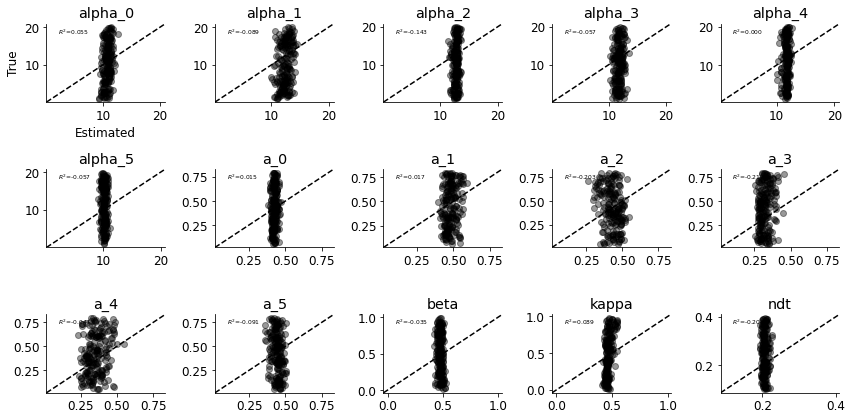

In [39]:
plot_true_est_scatter(theta_samples.mean(0), test_data['theta'], param_names, figsize=(12, 6))

In [29]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=20)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/asd_online_std_new\ckpt-19


# Train

In [250]:
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

In [428]:
# %%time
# for ep in range(1, 2+1):
#     with tqdm(total=iterations, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_online(model, 
#                               optimizer, 
#                               sim, 
#                               maximum_likelihood_loss, 
#                               iterations, 
#                               batch_size, 
#                               p_bar=p_bar, 
#                               clip_value=clip_value, 
#                               global_step=global_step)
#         # Plot stuff
#         theta_samples = model.sample(test_data['x'], 1000, to_numpy=True)
#         theta_samples = theta_samples*theta_stds + theta_means
#         plot_true_est_scatter(theta_samples.mean(0), test_data['theta'], 
#                               param_names, figsize=(12, 6), font_size_metric=12)
        
#         # Store checkpoint
#         manager.save()

Instructions for updating:
Colocations handled automatically by placer.


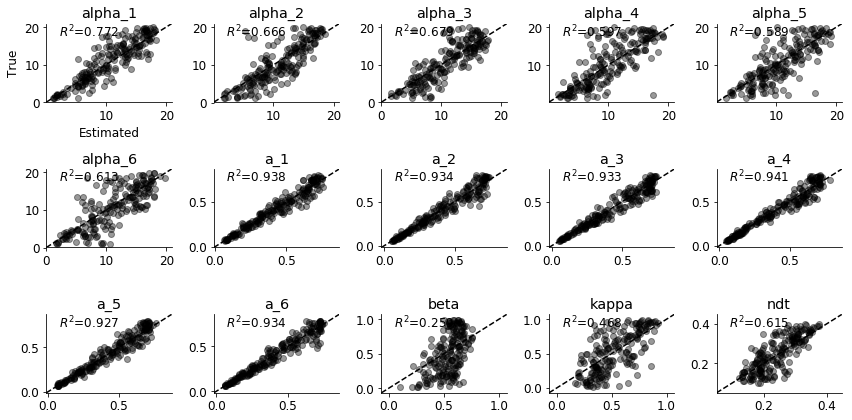

In [15]:
theta_samples = model.sample(test_data['x'], 1000, to_numpy=True)
theta_samples = theta_samples*theta_stds + theta_means
plot_true_est_scatter(theta_samples.mean(0), test_data['theta'], 
                      param_names, figsize=(12, 6), font_size_metric=12)

# Real Data

## Sample from control participants

In [31]:
def estimate_posteriors(data_file, n_posterior_samples=20000, n_cond=6):
    """
    Loads and estimates posteriors from all datasets.
    """
    
    # Load data (expects pickle format)
    datalist = pickle.load(open(data_file, 'rb+'))
    
    # Prepare data structures 
    posteriors = []
    posterior_medians = []
    posterior_means = []
    data_lists = []

    # Loop through all datasets
    for data_f in datalist:

        # Prepare data for estimation, some custom hardcoding because of the format
        data = []
        for c in range(n_cond):
            idx_c = data_f[:, -6:].argmax(axis=1) == c
            data_c = data_f[idx_c, :]
            data_c[:, 0][data_c[:, 0] >= 2] = -1.
            data.append(data_c[np.newaxis])

        # Sample from posterior and add back means and stds (de-normalize posteriors)
        theta_samples = model.sample(data, n_posterior_samples, to_numpy=True)
        theta_samples = theta_samples*theta_stds + theta_means
        theta_samples = theta_samples[(theta_samples < 0).sum(axis=1) == 0]

        # Store posterior and point estimates
        posteriors.append(theta_samples)
        posterior_means.append(theta_samples.mean(axis=0))
        posterior_medians.append(np.median(theta_samples, axis=0))
        data_lists.append(data)
        
    posterior_means = np.array(posterior_means)
    posterior_medians = np.array(posterior_medians)
    return {'posteriors': posteriors, 
            'posterior_means': posterior_means, 
            'posterior_medians': posterior_medians,
            'data': data_lists}

In [32]:
est_control_last = estimate_posteriors('estimation_data/control_last.pkl')
est_exp_last = estimate_posteriors('estimation_data/exp_last.pkl')

In [33]:
par_names_l = [r'$\alpha_{}$'.format(i) for i in range(1, 7)] 
par_names_l += [r'$a_{}$'.format(i) for i in range(1, 7)] 
par_names_l += [r'$\beta$', r'$\kappa$', r'$\tau$']

In [93]:
def plot_posteriors(samples, figsize=(18, 6), font_size=16, filename=None, 
                    bins_post=30,bins_prior=30, map_samples=5000):
    """Plots univariate posteriors."""
    
    # Plot settings
    f, ax = plt.subplots(3, 5, figsize=figsize)
    plt.rcParams['font.size'] = font_size
    for i in range(theta_dim):
        
        
        sns.kdeplot(theta_only[:50000, i], color='gray', alpha=0.2, ax=ax.flat[i], fill=True, label='Prior')
        sns.histplot(samples[:, i], bins=bins_post, ax=ax.flat[i], stat='density',
                     color='#a34f4f', element='step', label='Posterior', zorder=10)
#         sns.kdeplot(theta_only[:100, i], color='gray', alpha=0.2, 
#                      bins=bins_prior, edgecolor=None, ax=ax.flat[i])
        
        
        
        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed', label='Median')
        ax.flat[i].set_title(par_names_l[i], pad=0.4)
#         ax.flat[i].set_ylim([0, ax.flat[i].get_ylim()[1]])
#         med = np.median(samples[:, i])
#         ax.flat[i].text(0.1, 0.85, r'$Med={:.2f}$'.format(med),
#                      horizontalalignment='left',
#                      verticalalignment='center',
#                      transform=ax.flat[i].transAxes,
#                      size=12)
        
        ax.flat[i].set_ylabel('')
        ax.flat[i].set_yticks([])
        
        if i == 0:
            lg = ax.flat[0].legend(fontsize=10)
        
    f.tight_layout()
    plt.show()

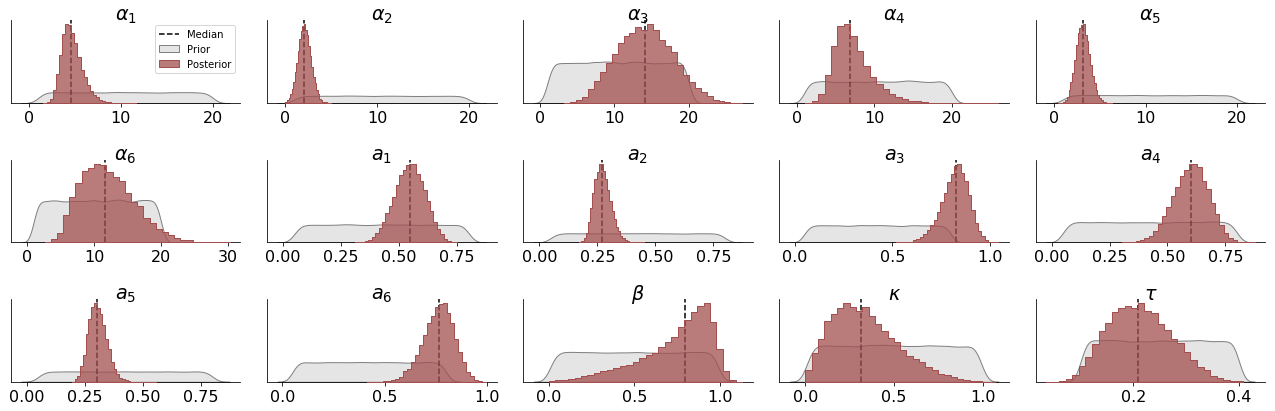

In [95]:
plot_posteriors(est_control_last['posteriors'][3])

In [34]:
for i, pname in enumerate(param_names):
    
    # Differences in medians
    print('Parameter', pname)
    print('Control: ', est_control_last['posterior_means'][:, i].mean(), 
          'Exp: ', est_exp_last['posterior_means'][:, i].mean())

Parameter alpha_1
Control:  8.97764295620512 Exp:  8.231763562799877
Parameter alpha_2
Control:  12.898551383080099 Exp:  12.50393116873696
Parameter alpha_3
Control:  12.72839324042226 Exp:  10.74575424854311
Parameter alpha_4
Control:  7.564846035118409 Exp:  7.267219866947526
Parameter alpha_5
Control:  11.31275989052476 Exp:  10.822108602455375
Parameter alpha_6
Control:  5.48527090074853 Exp:  4.724033074177662
Parameter a_1
Control:  0.2544895885778319 Exp:  0.2676910630548604
Parameter a_2
Control:  0.20268858549213217 Exp:  0.24618726156123166
Parameter a_3
Control:  0.28239843221384725 Exp:  0.2609829408069247
Parameter a_4
Control:  0.25812432085880227 Exp:  0.27065032647439313
Parameter a_5
Control:  0.2198004983609084 Exp:  0.24577193878415704
Parameter a_6
Control:  0.2753776312058203 Exp:  0.2756073148398265
Parameter beta
Control:  0.38678710146194895 Exp:  0.3466975159204933
Parameter kappa
Control:  0.3936579061222714 Exp:  0.4123565382547307
Parameter ndt
Control:  0.

## Some predictions

In [391]:
# Parameter posteriors
f, ax = plt.subplots(3, 5, figsize=(12, 6))
for i, ax in enumerate(ax.flat):
    sns.histplot(theta_samples[:, i], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(param_names[i])
f.tight_layout()

In [396]:
def posterior_predictive(theta_samples, data, n_resim=100, dt=0.005):
    """
    Performs a posterior predictive check on the data.
    """
    
    # Compute predicted accuracies
    accuracies = []
    means = []
    omission_rates = []
    
    # Get some random samples
    r_idx = np.random.permutation(theta_samples.shape[0])[:n_resim]
    for idx in r_idx:
        
        # Decompose sample
        s = theta_samples[idx]
        alphas = s[:6]
        a_s = s[6:12]
        beta, kappa, ndt = s[12:]
        
        # Simulate and split conditions
        sim_data = sim.simulate_single(alphas, a_s, beta, kappa, ndt, dt=dt)
        sim_data = np.split(sim_data, 6, axis=0)
        
        # Compute metrics
        for d in sim_data:
            
            # Calculate acc, mean rt and omission rate
            acc = (d[:, 1:8].argmax(1) == d[:, -6:].argmax(1)).sum() / d.shape[0]
            meanrt = d[:, 0][d[:, 0] != -1].mean()
            omit = (d[:, 0] == -1).sum() / d.shape[0]
            
            # Add to list
            accuracies.append(acc)
            means.append(meanrt)
            omission_rates.append(omit)
    means = np.array(means).reshape(-1, 6)
    accuracies = np.array(accuracies).reshape(-1, 6)
    omission_rates = np.array(omission_rates).reshape(-1, 6)

    
    # Compute true means and accs and omissions
    true_means = []
    true_accs = []
    true_omissions = []
    for d in data:
        acc = (d[0, :, 1:8].argmax(1) == d[0, :, -6:].argmax(1)).sum() / d.shape[1]
        m = d[0, :, 0][d[0, :, 0] != -1].mean()
        om = (d[0, :, 0] == -1).sum() / d.shape[1]
        true_means.append(m)
        true_accs.append(acc)
        true_omissions.append(om)


    # Emotion titles
    emotion_titles = ['Contempt', 'Happiness', 'Fear', 'Anger', 'Neutral', 'Sadness']
    f, ax = plt.subplots(3, 6, figsize=(24, 9))

    for i in range(6):

        # Plot means
        sns.kdeplot(means[:, i], ax=ax[0, i], shade=True, color='#b36f68', label='Model predictions')
        ax[0, i].axvline(true_means[i], color='black', linestyle='dashed', label='Mean RT')
        sns.despine(ax=ax[0, i])
        ax[0, i].set_ylabel('')
        ax[0, i].set_title(emotion_titles[i])
        ax[0, i].set_yticks([])
        ax[0, i].set_ylim([0, ax[0, i].get_ylim()[1]])

        # Plot accuracies
        sns.kdeplot(accuracies[i], ax=ax[1, i], shade=True, color='#687bb3', label='Model predictins')
        ax[1, i].axvline(true_accs[i], color='black', linestyle='dashed', label='Accuracy')
        sns.despine(ax=ax[1, i])
        ax[1, i].set_ylabel('')
        ax[1, i].set_xlim([0.0, 1.0])
        ax[1, i].set_yticks([])
        ax[1, i].set_ylim([0, ax[1, i].get_ylim()[1]])
        
        # Plot omissions
        sns.kdeplot(omission_rates[i], ax=ax[2, i], shade=True, color='#68b369', label='Model predictins')
        ax[2, i].axvline(true_omissions[i], color='black', linestyle='dashed', label='Omission rate')
        sns.despine(ax=ax[2, i])
        ax[2, i].set_ylabel('')
        ax[2, i].set_xlim([0.0, 1.0])
        ax[2, i].set_yticks([])
        ax[2, i].set_ylim([0, ax[2, i].get_ylim()[1]])

        if i == 0:
            ax[0, i].legend()
            ax[1, i].legend()
            ax[2, i].legend()

    f.tight_layout()
    return f

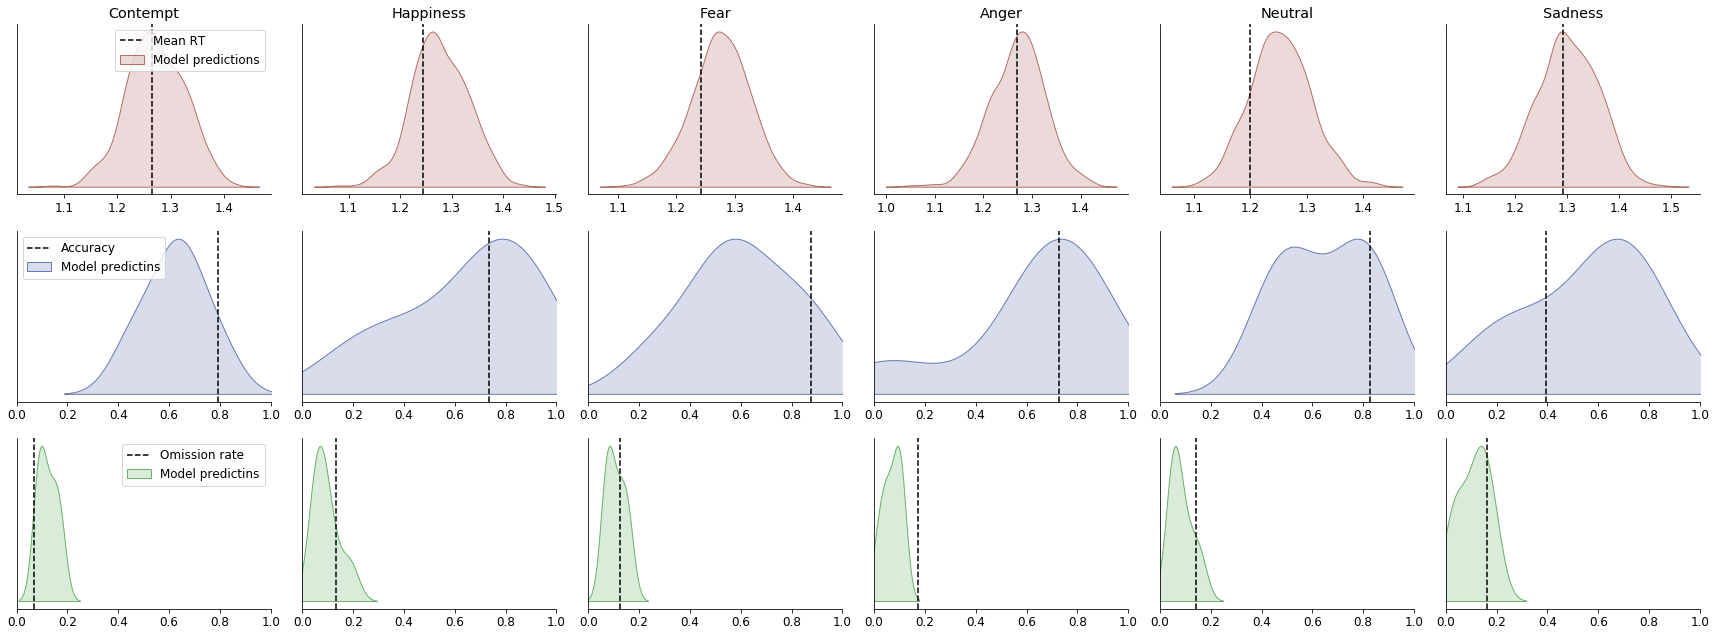

In [397]:
f = posterior_predictive(est_control_last['posteriors'][0], 
                     est_control_last['data'][0], n_resim=500)

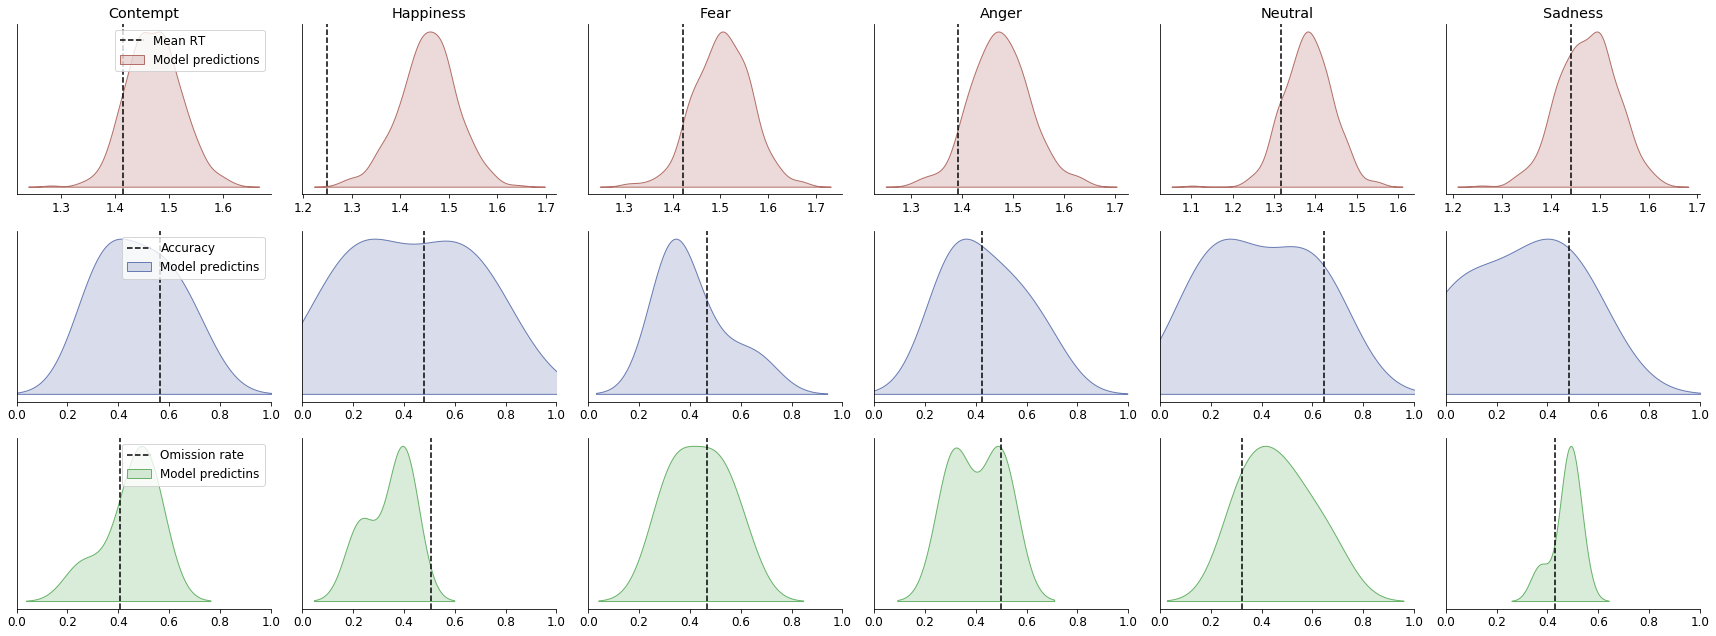

In [398]:
f = posterior_predictive(est_control_last['posteriors'][1], 
                     est_control_last['data'][1], n_resim=500)

In [399]:
from scipy.stats import dirichlet

In [419]:
# Compute entropy
ent_ctl = np.zeros((10, 6))
for i in range(10):
    for j in range(6):
        alpha0 = est_control_last['posteriors'][i][:, j]
        dir_params = np.ones((alpha0.shape[0], 6))
        dir_params[:, j] = alpha0
        entropies = [dirichlet(p).entropy() for p in dir_params]
        ent_ctl[i, j] = np.mean(entropies)

In [420]:
# Compute entropy
ent_exp = np.zeros((10, 6))
for i in range(10):
    for j in range(6):
        alpha0 = est_exp_last['posteriors'][i][:, j]
        dir_params = np.ones((alpha0.shape[0], 6))
        dir_params[:, j] = alpha0
        entropies = [dirichlet(p).entropy() for p in dir_params]
        ent_exp[i, j] = np.mean(entropies)

In [425]:
ent_ctl.mean()

-8.20755888522209

In [426]:
ent_exp.mean()

-8.717198145225987